In [ ]:
import warnings
warnings.simplefilter("ignore")
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.impute import KNNImputer

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.svm import OneClassSVM

from sklearn.manifold import MDS, TSNE
from sklearn.svm import SVR

import pandas as pd
import itertools

from scipy.spatial.distance import cdist, pdist, squareform
from scipy.stats import spearmanr
from scipy.cluster import hierarchy


# These data were aggregated from a number of sources including the American Community Survey (census.gov), clinicaltrials.gov, and cancer.gov.

## OLS Regression Challenge 
### cancer_reg.csv

<pre><code>

TARGET_deathRate: Dependent variable. Mean per capita (100,000) cancer mortalities(a)

avgAnnCount: Mean number of reported cases of cancer diagnosed annually(a)

avgDeathsPerYear: Mean number of reported mortalities due to cancer(a)

incidenceRate: Mean per capita (100,000) cancer diagoses(a)

medianIncome: Median income per county (b)

popEst2015: Population of county (b)

povertyPercent: Percent of populace in poverty (b)

studyPerCap: Per capita number of cancer-related clinical trials per county (a)

binnedInc: Median income per capita binned by decile (b)

MedianAge: Median age of county residents (b)

MedianAgeMale: Median age of male county residents (b)

MedianAgeFemale: Median age of female county residents (b)

Geography: County name (b)

AvgHouseholdSize: Mean household size of county (b)

PercentMarried: Percent of county residents who are married (b)

PctNoHS18_24: Percent of county residents ages 18-24 highest education attained: less than high school (b)

PctHS18_24: Percent of county residents ages 18-24 highest education attained: high school diploma (b)

PctSomeCol18_24: Percent of county residents ages 18-24 highest education attained: some college (b)

PctBachDeg18_24: Percent of county residents ages 18-24 highest education attained: bachelor's degree (b)

PctHS25_Over: Percent of county residents ages 25 and over highest education attained: high school diploma (b)

PctBachDeg25_Over: Percent of county residents ages 25 and over highest education attained: bachelor's degree (b)

PctEmployed16_Over: Percent of county residents ages 16 and over employed (b)

PctUnemployed16_Over: Percent of county residents ages 16 and over unemployed (b)

PctPrivateCoverage: Percent of county residents with private health coverage (b)

PctPrivateCoverageAlone: Percent of county residents with private health coverage alone (no public assistance) (b)

PctEmpPrivCoverage: Percent of county residents with employee-provided private health coverage (b)

PctPublicCoverage: Percent of county residents with government-provided health coverage (b)

PctPubliceCoverageAlone: Percent of county residents with government-provided health coverage alone (b)

PctWhite: Percent of county residents who identify as White (b)

PctBlack: Percent of county residents who identify as Black (b)

PctAsian: Percent of county residents who identify as Asian (b)

PctOtherRace: Percent of county residents who identify in a category which is not White, Black, or Asian (b)

PctMarriedHouseholds: Percent of married households (b)

BirthRate: Number of live births relative to number of women in county (b)

</code></pre>

## Objetivo predecir la cantidad de muertes por cancer en los condados de USA

In [ ]:
df = pd.read_csv('/home/aeb/Documents/jupiter/cancer_reg.csv', sep=',', comment='#', header=0)
print(df.shape)
df.head(5)

(3047, 34)


,avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,...,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
0,1397.0,469,164.9,489.8,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,...,NaN,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.0,70,161.3,411.6,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,...,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.0,50,174.7,349.7,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,...,43.5,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.0,202,194.8,430.4,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,...,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.0,26,144.4,350.1,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,...,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657


## Preprocesamiento 
quitar
* medIncome - binnedInc
* Geography - County/City, State

In [ ]:
y_=df['TARGET_deathRate'].to_numpy()

df.drop(['TARGET_deathRate'], axis=1, inplace=True)
df.drop(['binnedInc'], axis=1, inplace=True)
df.drop(['Geography'], axis=1, inplace=True)


### Hay valores NA ?

In [ ]:
X_ = df.to_numpy()
print('NaNs: ', np.sum(np.isnan(X_)))

NaNs:  3046


### Divido test y train - Normalizo los datos
### [KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) imputar valores faltantes

In [ ]:
st = StandardScaler(with_mean=True, with_std=True)
st_y = StandardScaler(with_mean=True, with_std=True)

t_for_test_only = KFold(n_splits=5, random_state=0, shuffle=True)
train, test = list(t_for_test_only.split(X_, y_))[0]


X = X_[train]
y = y_[train]
X_te = X_[test]
y_te = y_[test]

imputer = KNNImputer(n_neighbors=1)
X = imputer.fit_transform(X)
X_te = imputer.transform(X_te)
print('NaNs: ', np.sum(np.isnan(X)))
print('NaNs: ', np.sum(np.isnan(X_te)))

X = st.fit_transform(X)
y = st_yt.fit_transform(y.reshape(-1, 1)).ravel()
X_te = st.transform(X_te)
y_te = st_y.transform(y_te.reshape(-1, 1)).ravel()

NaNs:  0
NaNs:  0


### Visualizacion - PCA - Kernel PCA y t-SNE

In [ ]:
pc = PCA(n_components=20)
x_pc = pc.fit_transform(X)
print(pc.explained_variance_ratio_.sum())
kpc = KernelPCA(n_components=2, kernel='rbf', degree=3, gamma=0.0005, fit_inverse_transform=True)
x_kpc = kpc.fit_transform(X)

kpc2 = KernelPCA(n_components=2, kernel='poly', degree=2, gamma=0.0005, fit_inverse_transform=True)
x_kpc2 = kpc2.fit_transform(X)

0.9715340648500164


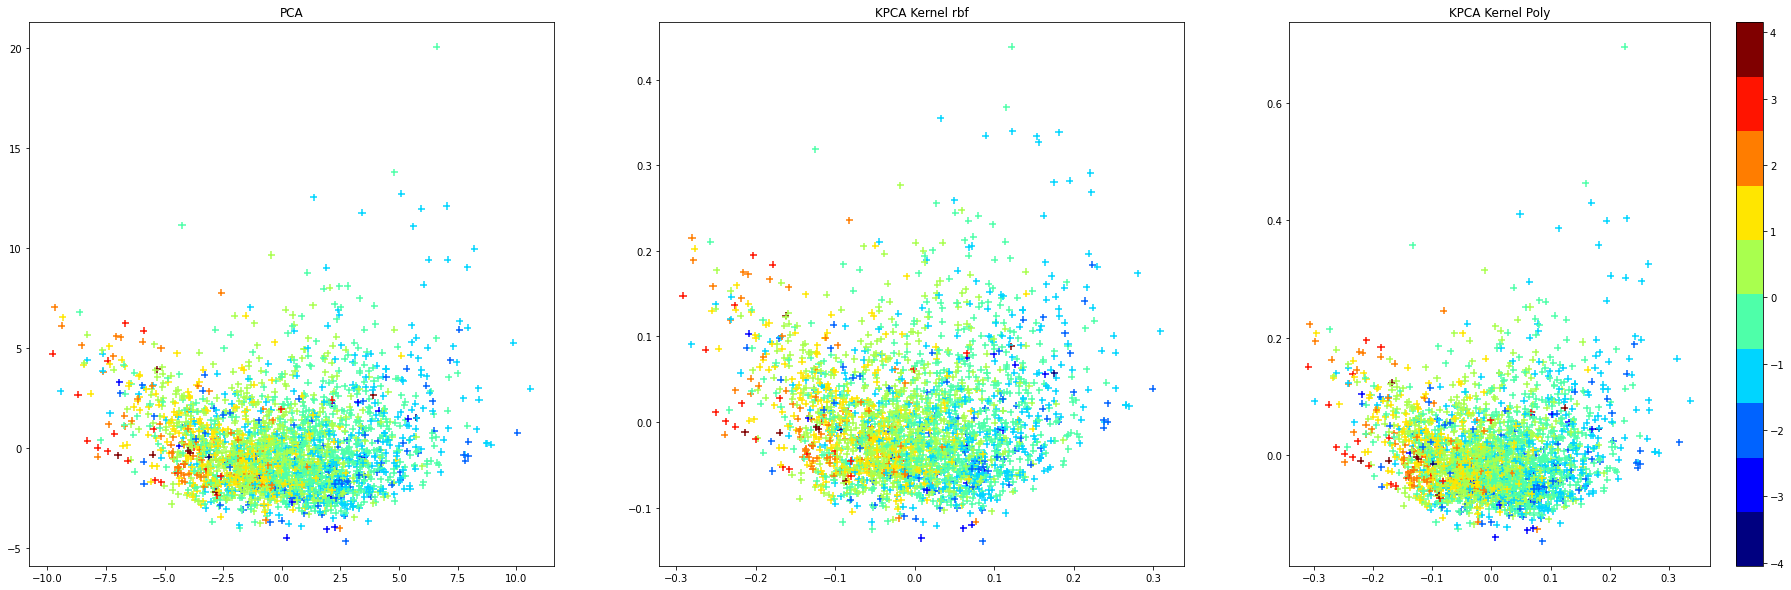

In [ ]:
fig, ax = plt.subplots(1, 3,  figsize=(32, 10))
sc = ax[0].scatter(x_pc[:, 0], x_pc[:, 1], c=y, marker='+', cmap=plt.cm.get_cmap('jet', 10), s=50, vmin=y.min(), vmax=y.max())
ax[0].set_title('PCA')

ax[1].scatter(x_kpc[:, 0], x_kpc[:, 1], c=y, marker='+', cmap=plt.cm.get_cmap('jet', 10), s=50)
ax[1].set_title('KPCA Kernel rbf')

ax[2].scatter(x_kpc2[:, 0], x_kpc2[:, 1], c=y, marker='+', cmap=plt.cm.get_cmap('jet', 10), s=50)
ax[2].set_title('KPCA Kernel Poly')

plt.colorbar(sc)


In [ ]:
model_tsne = TSNE(n_components=2, metric='euclidean')
x_tsne = model_tsne.fit_transform(X)

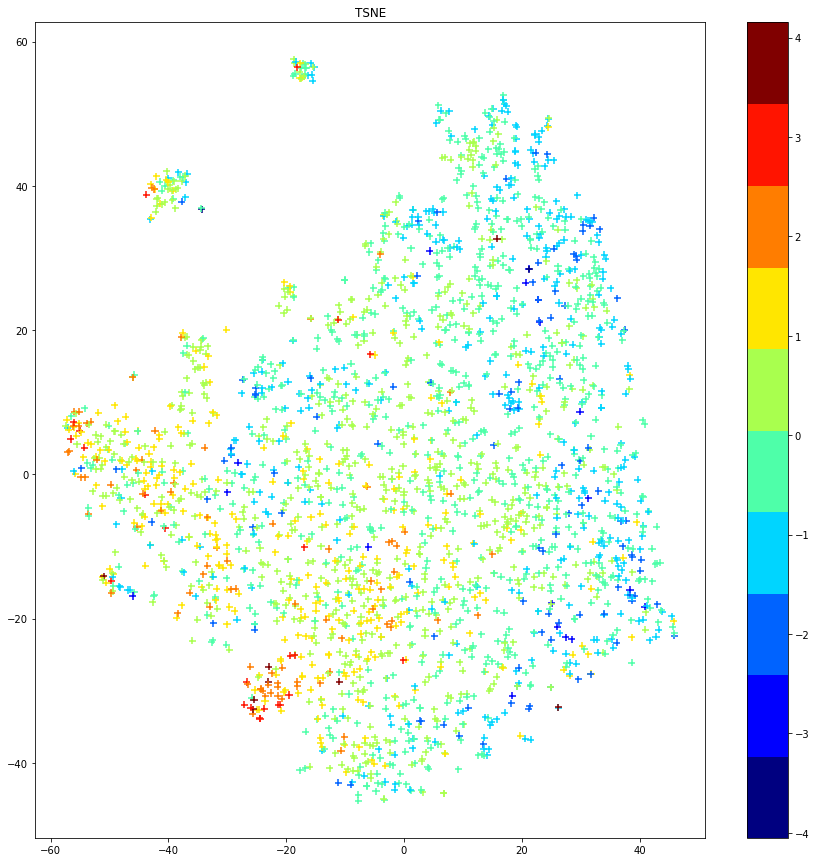

In [ ]:
fig, ax = plt.subplots(1, 1,  figsize=(15, 15))
sc = ax.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, marker='+', cmap=plt.cm.get_cmap('jet', 10), s=50, vmin=y.min(), vmax=y.max())
ax.set_title('TSNE')
plt.colorbar(sc)

### Quitar outliers

* Usamos [OneClassSVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html)


In [ ]:
clf = OneClassSVM(gamma='auto', nu=0.2).fit(X)
y_out = clf.fit_predict(X)
y_te_out = clf.predict(X_te)

print('Before tr: ', X.shape)
print('Before te: ', X_te.shape)

X = X[y_out>0]
y = y[y_out>0]
X_te_ = X_te[y_te_out>0]
y_te_ = y_te[y_te_out>0]

print('After tr: ', X.shape)
print('After te: ', X_te_.shape)

Before tr:  (2437, 31)
Before te:  (610, 31)
After tr:  (1948, 31)
After te:  (476, 31)


### Como quedan los datos
Visualizacion - PCA - Kernel PCA y t-SNE

In [ ]:
x_pc = pc.transform(X)
x_kpc = kpc.transform(X)
x_kpc2 = kpc2.transform(X)

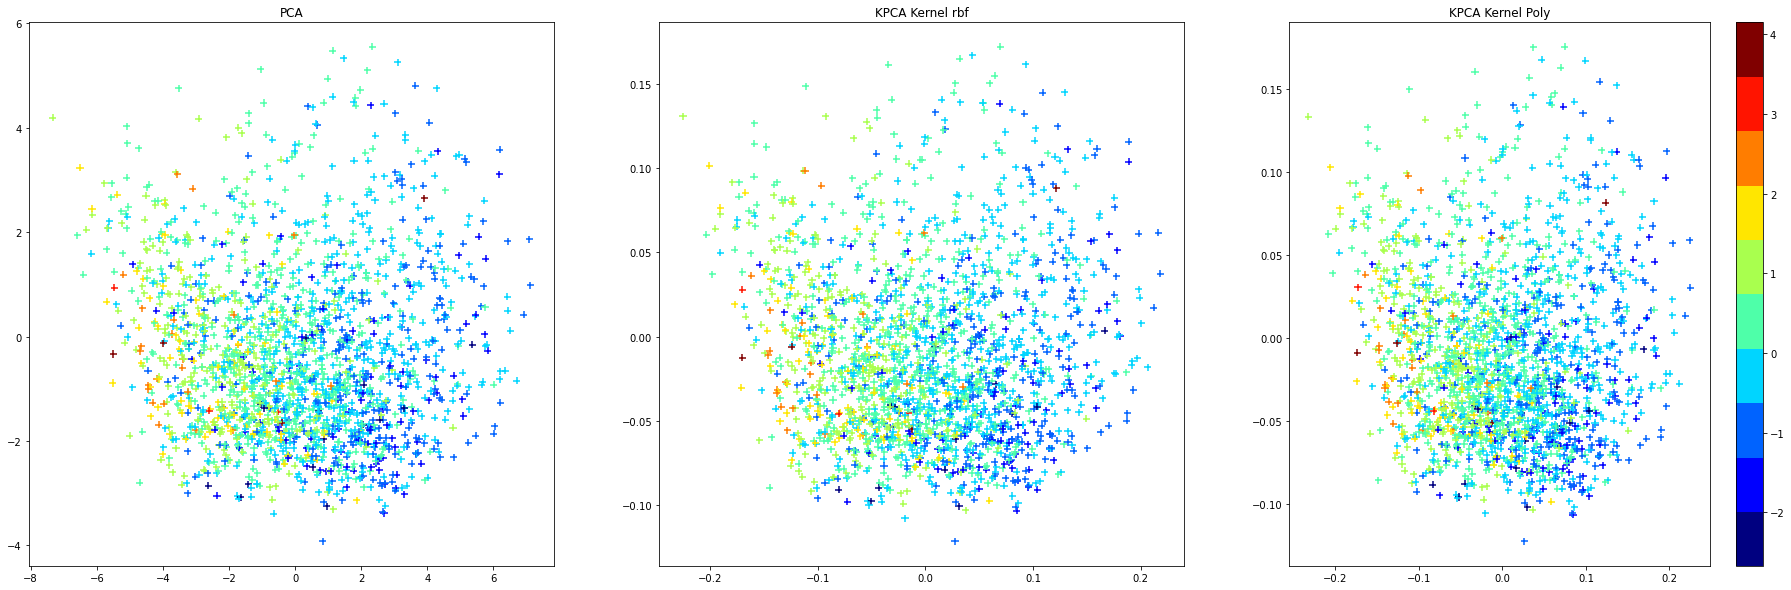

In [ ]:
fig, ax = plt.subplots(1, 3,  figsize=(32, 10))
sc = ax[0].scatter(x_pc[:, 0], x_pc[:, 1], c=y, marker='+', cmap=plt.cm.get_cmap('jet', 10), s=50, vmin=y.min(), vmax=y.max())
ax[0].set_title('PCA')

ax[1].scatter(x_kpc[:, 0], x_kpc[:, 1], c=y, marker='+', cmap=plt.cm.get_cmap('jet', 10), s=50)
ax[1].set_title('KPCA Kernel rbf')

ax[2].scatter(x_kpc2[:, 0], x_kpc2[:, 1], c=y, marker='+', cmap=plt.cm.get_cmap('jet', 10), s=50)
ax[2].set_title('KPCA Kernel Poly')

plt.colorbar(sc)


### TSNE

In [ ]:
model_tsne = TSNE(n_components=2, metric='euclidean')
x_tsne = model_tsne.fit_transform(X)

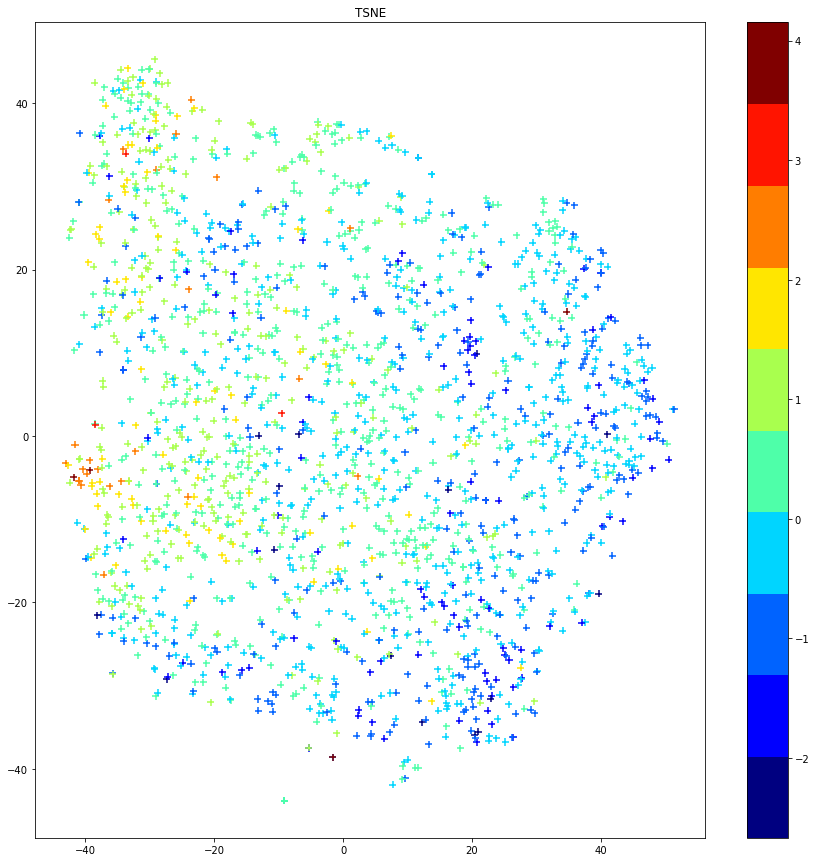

In [ ]:
fig, ax = plt.subplots(1, 1,  figsize=(15, 15))
sc = ax.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, marker='+', cmap=plt.cm.get_cmap('jet', 10), s=50, vmin=y.min(), vmax=y.max())
ax.set_title('TSNE')
plt.colorbar(sc)

### Entrenamos 5 modelos de regresion usamos [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) y [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) 

* [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) 
    - Lin
    - poly
    - rbf
* [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) 
* [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) 
* [GBM](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)
* [RF](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

In [ ]:
svr_rbf = SVR(kernel='rbf', gamma='auto')
svr_lin = SVR(kernel='linear', gamma='auto')
svr_poly = SVR(kernel='poly', gamma='auto', degree=2, coef0=1)

In [ ]:
results_in_color = []

results_in_color_x = []
results_in_color_x.append('Train w/o outliers')
results_in_color_x.append('Test w outliers')
results_in_color_x.append('Test w/o outliers')

results_in_color_y = []

### SVR rbf

In [ ]:
par = np.logspace(-5, 2, 8)
eps = np.logspace(-4, 0, 5)
cv = KFold(n_splits=5, random_state=0, shuffle=True)
tunner_svr_rbf = GridSearchCV(estimator=svr_rbf, param_grid={'C':par, 'epsilon':eps}, cv=cv, n_jobs=12)
_=tunner_svr_rbf.fit(X, y)
print('RMSE train test')
print(np.sqrt(np.mean((tunner_svr_rbf.predict(X)-y)**2)))
print(np.sqrt(np.mean((tunner_svr_rbf.predict(X_te)-y_te)**2)))
print(np.sqrt(np.mean((tunner_svr_rbf.predict(X_te_)-y_te_)**2)))
print('R2 train test')
print(tunner_svr_rbf.score(X, y))
print(tunner_svr_rbf.score(X_te, y_te))
print(tunner_svr_rbf.score(X_te_, y_te_))

results_in_color.append([tunner_svr_rbf.score(X, y), tunner_svr_rbf.score(X_te, y_te), tunner_svr_rbf.score(X_te_, y_te_)])
results_in_color_y.append('SVR rbf')

RMSE train test
0.5517478073363193
0.7493795431780902
0.5832844597318388
R2 train test
0.6091057426971567
0.4520113389172097
0.5391704459854025


### SVR lin

In [ ]:
par = np.logspace(-5, 2, 8)
tunner_svr_lin = GridSearchCV(estimator=svr_lin, param_grid={'C':par, 'epsilon':eps}, cv=cv, n_jobs=12)
_=tunner_svr_lin.fit(X, y)
print('RMSE train test')
print(np.sqrt(np.mean((tunner_svr_lin.predict(X)-y)**2)))
print(np.sqrt(np.mean((tunner_svr_lin.predict(X_te)-y_te)**2)))
print(np.sqrt(np.mean((tunner_svr_lin.predict(X_te_)-y_te_)**2)))
print('R2 train test')
print(tunner_svr_lin.score(X, y))
print(tunner_svr_lin.score(X_te, y_te))
print(tunner_svr_lin.score(X_te_, y_te_))
results_in_color.append([tunner_svr_lin.score(X, y), tunner_svr_lin.score(X_te, y_te), tunner_svr_lin.score(X_te_, y_te_)])
results_in_color_y.append('SVR lin')

RMSE train test
0.6345402998890626
0.7318746613778256
0.6113469817052533
R2 train test
0.48299293562352863
0.47731344569072653
0.4937616328150365


### SVR poly

In [ ]:
par = np.logspace(-5, 2, 8)
# tunner_svc = GridSearchCV(estimator=svc, param_grid={'C':par, 'gamma':par_gamma}, cv=cv, n_jobs=12)
tunner_svr_poly = GridSearchCV(estimator=svr_poly, param_grid={'C':par, 'epsilon':eps}, cv=cv, n_jobs=12)
_=tunner_svr_poly.fit(X, y)
print('RMSE train test')
print(np.sqrt(np.mean((tunner_svr_poly.predict(X)-y)**2)))
print(np.sqrt(np.mean((tunner_svr_poly.predict(X_te)-y_te)**2)))
print(np.sqrt(np.mean((tunner_svr_poly.predict(X_te_)-y_te_)**2)))
print('R2 train test')
print(tunner_svr_poly.score(X, y))
print(tunner_svr_poly.score(X_te, y_te))
print(tunner_svr_poly.score(X_te_, y_te_))
results_in_color.append([tunner_svr_poly.score(X, y), tunner_svr_poly.score(X_te, y_te), tunner_svr_poly.score(X_te_, y_te_)])
results_in_color_y.append('SVR poly')

RMSE train test
0.5771225436372668
1.3158121563194427
0.5805514024831223
R2 train test
0.5723247316806999
-0.6894902668662897
0.5434788852598388


### Ridge reg.

In [ ]:
alpha_par = np.arange(0, 1, 0.05)
lmr = Ridge()
tunner_lmr = GridSearchCV(estimator=lmr, param_grid={'alpha':alpha_par}, cv=cv, n_jobs=12)
_=tunner_lmr.fit(X, y)
print('RMSE train test')
print(np.sqrt(np.mean((tunner_lmr.predict(X)-y)**2)))
print(np.sqrt(np.mean((tunner_lmr.predict(X_te)-y_te)**2)))
print(np.sqrt(np.mean((tunner_lmr.predict(X_te_)-y_te_)**2)))
print('R2 train test')
print(tunner_lmr.score(X, y))
print(tunner_lmr.score(X_te, y_te))
print(tunner_lmr.score(X_te_, y_te_))
results_in_color.append([tunner_lmr.score(X, y), tunner_lmr.score(X_te, y_te), tunner_lmr.score(X_te_, y_te_)])
results_in_color_y.append('Ridge reg.')

RMSE train test
0.6306736268450381
0.7484627783669158
0.6056630626120444
R2 train test
0.4892746686194124
0.4533512992374221
0.5031312438448543


### Lasso reg.

In [ ]:
alpha_par = np.arange(0, 1, 0.05)
lml = Lasso()
tunner_lml = GridSearchCV(estimator=lml, param_grid={'alpha':alpha_par}, cv=cv, n_jobs=12)
_=tunner_lml.fit(X, y)
print('RMSE train test')
print(np.sqrt(np.mean((tunner_lml.predict(X)-y)**2)))
print(np.sqrt(np.mean((tunner_lml.predict(X_te)-y_te)**2)))
print(np.sqrt(np.mean((tunner_lml.predict(X_te_)-y_te_)**2)))
print('R2 train test')
print(tunner_lml.score(X, y))
print(tunner_lml.score(X_te, y_te))
print(tunner_lml.score(X_te_, y_te_))
results_in_color.append([tunner_lml.score(X, y), tunner_lml.score(X_te, y_te), tunner_lml.score(X_te_, y_te_)])
results_in_color_y.append('Lasso reg.')

RMSE train test
0.6305822447446215
1.223073281493671
0.6060146585939236
R2 train test
0.48942266203565443
-0.4597311080921562
0.5025541977080485


### 5-CV Error

(-0.05, 0.7)

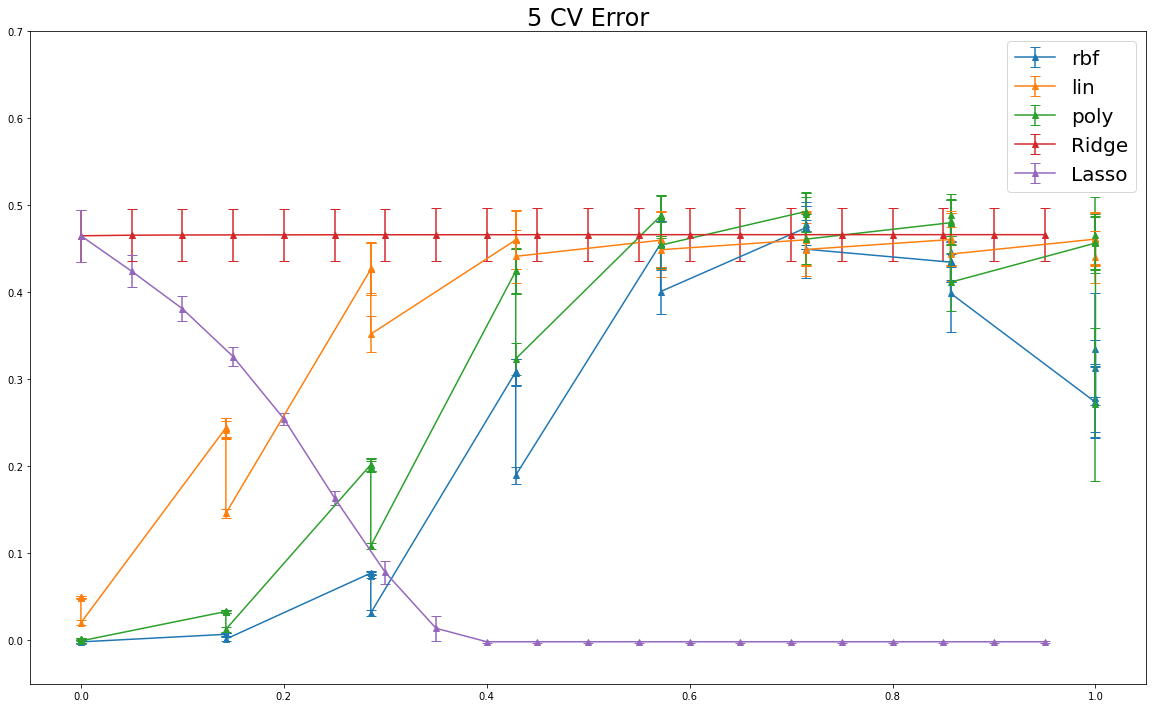

In [ ]:
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111)
xx = np.log10(np.array(tunner_svr_rbf.cv_results_['param_C'], dtype=np.float64))
xx -= xx.min()
xx /= xx.max()
ax.errorbar(xx, tunner_svr_rbf.cv_results_['mean_test_score'], yerr=tunner_svr_rbf.cv_results_['std_test_score'], capsize=5,marker='^', label='rbf')
ax.errorbar(xx, tunner_svr_lin.cv_results_['mean_test_score'], yerr=tunner_svr_lin.cv_results_['std_test_score'], capsize=5,marker='^', label='lin')
ax.errorbar(xx, tunner_svr_poly.cv_results_['mean_test_score'], yerr=tunner_svr_poly.cv_results_['std_test_score'], capsize=5,marker='^', label='poly')
ax.errorbar(tunner_lmr.cv_results_['param_alpha'], tunner_lmr.cv_results_['mean_test_score'], yerr=tunner_lmr.cv_results_['std_test_score'], capsize=5,marker='^', label='Ridge')
ax.errorbar(tunner_lml.cv_results_['param_alpha'], tunner_lml.cv_results_['mean_test_score'], yerr=tunner_lml.cv_results_['std_test_score'], capsize=5,marker='^', label='Lasso')
_=ax.set_title('5 CV Error', fontsize=24)
ax.legend(loc='best', fontsize=20)
ax.set_ylim([-0.05, 0.7])

### Importancia de variables [permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html) usando

* Ridge
* SVR Lineal

In [ ]:
result_lmr = permutation_importance(tunner_lmr, X, y, n_repeats=30, random_state=42, n_jobs=12)
perm_sorted_idx_lmr = result_lmr.importances_mean.argsort()

result_svr_lin = permutation_importance(tunner_svr_rbf, X, y, n_repeats=30, random_state=42, n_jobs=12)
perm_sorted_idx_svr_lin = result_svr_lin.importances_mean.argsort()

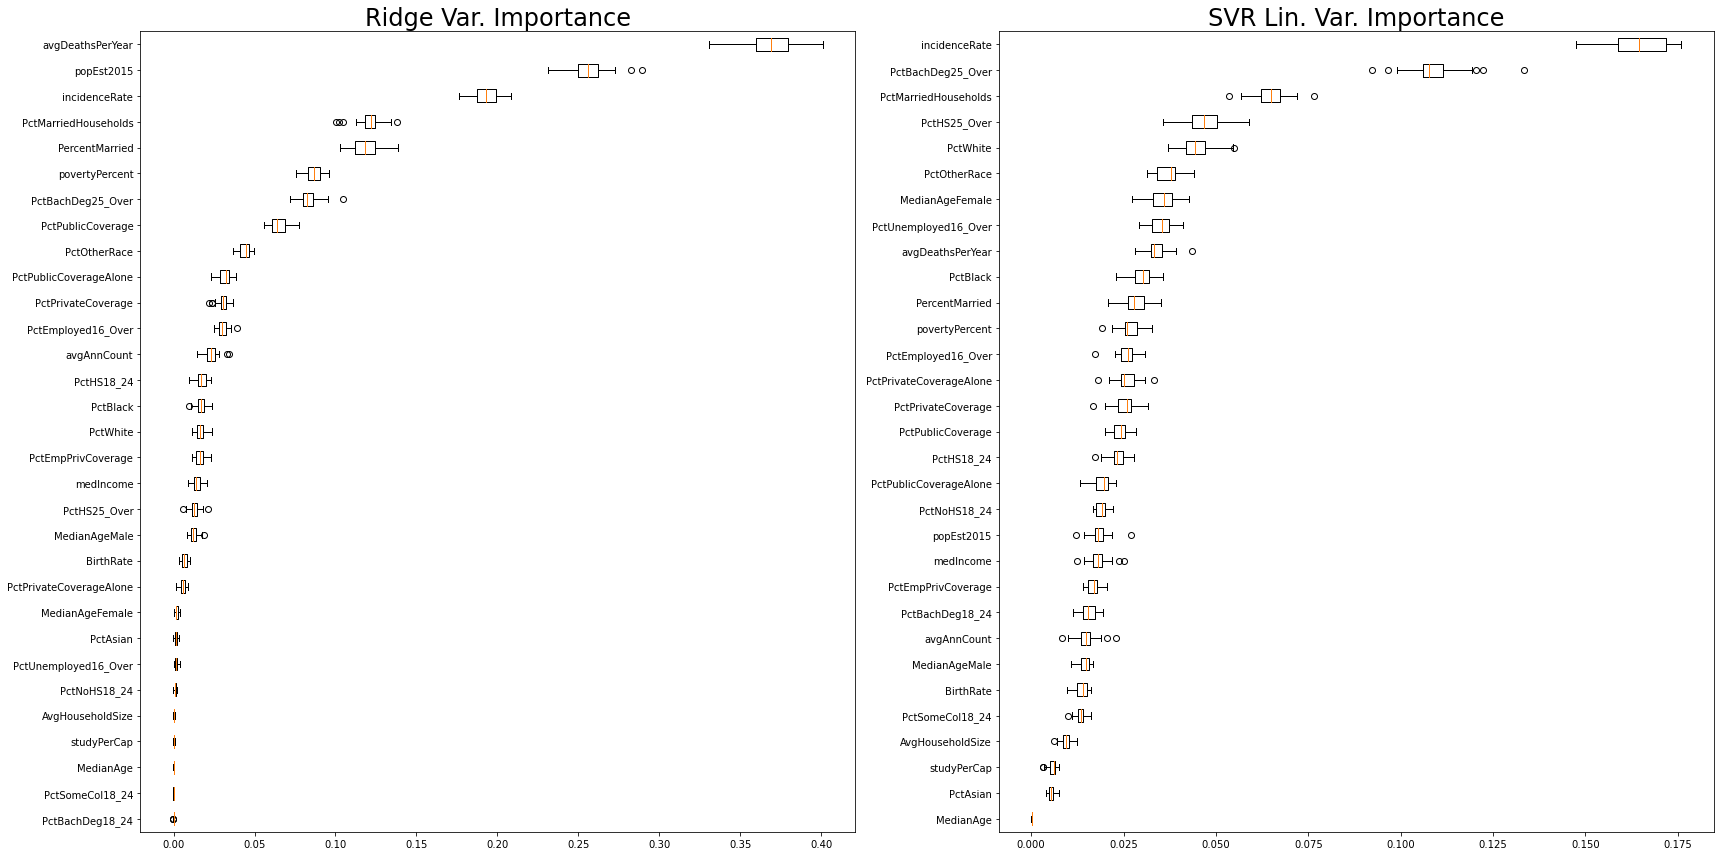

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].boxplot(result_lmr.importances[perm_sorted_idx_lmr].T, vert=False, labels=df.columns[perm_sorted_idx_lmr])
ax[0].set_title("Ridge Var. Importance", fontsize=24)
ax[1].boxplot(result_svr_lin.importances[perm_sorted_idx_svr_lin].T, vert=False, labels=df.columns[perm_sorted_idx_svr_lin])
ax[1].set_title("SVR Lin. Var. Importance", fontsize=24)
fig.tight_layout()
plt.show()


## GBM OOB J=6

In [ ]:
gbm = GradientBoostingRegressor(learning_rate=0.02, n_estimators=1000, subsample=0.6, max_depth=6)
gbm.fit(X, y)

GradientBoostingRegressor(learning_rate=0.02, max_depth=6, n_estimators=1000,
                          subsample=0.6)

n_estimators:  287  oob_improvement_:  -0.37765749668112675


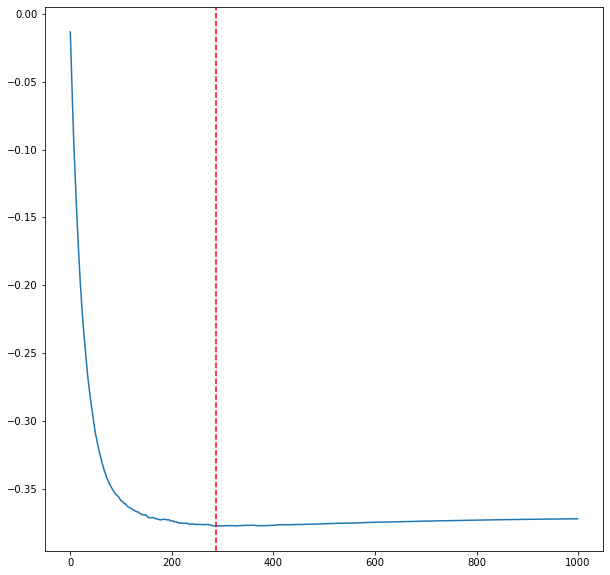

In [ ]:
cumsum_oob = -np.cumsum(gbm.oob_improvement_)
iimin = cumsum_oob.argmin()
print('n_estimators: ', iimin+1, ' oob_improvement_: ', cumsum_oob[iimin])
fig, ax = plt.subplots(1, 1,  figsize=(10, 10))
plt.plot(cumsum_oob)
plt.axvline(x=iimin, c='r', linestyle='--')

In [ ]:
gbm = GradientBoostingRegressor(learning_rate=0.02, n_estimators=iimin+1, subsample=0.6, max_depth=6)
gbm.fit(X, y)
print(gbm.oob_improvement_.sum())
print('RMSE train test')
print(np.sqrt(np.mean((gbm.predict(X)-y)**2)))
print(np.sqrt(np.mean((gbm.predict(X_te)-y_te)**2)))
print(np.sqrt(np.mean((gbm.predict(X_te_)-y_te_)**2)))
print('R2 train test')
print(gbm.score(X, y))
print(gbm.score(X_te, y_te))
print(gbm.score(X_te_, y_te_))
results_in_color.append([gbm.score(X, y), gbm.score(X_te, y_te), gbm.score(X_te_, y_te_)])
results_in_color_y.append('GBM J=6 reg.')

0.36385225526936504
RMSE train test
0.2697993525871121
0.6662564155935214
0.544823728267996
R2 train test
0.9065326639836728
0.5668376377854022
0.5979393786013281


## GBM OOB J=4

In [ ]:
gbm = GradientBoostingRegressor(learning_rate=0.02, n_estimators=1000, subsample=0.6, max_depth=4)
gbm.fit(X, y)


GradientBoostingRegressor(learning_rate=0.02, max_depth=4, n_estimators=1000,
                          subsample=0.6)

n_estimators:  417  oob_improvement_:  -0.36427648952470987


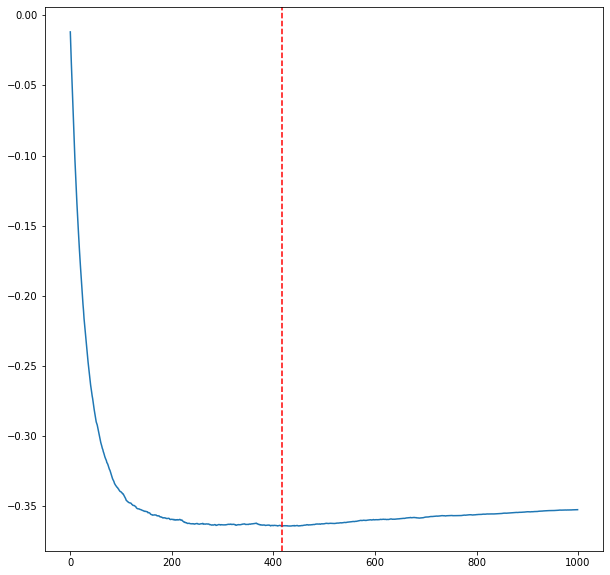

In [ ]:
cumsum_oob = -np.cumsum(gbm.oob_improvement_)
iimin = cumsum_oob.argmin()
print('n_estimators: ', iimin+1, ' oob_improvement_: ', cumsum_oob[iimin])
fig, ax = plt.subplots(1, 1,  figsize=(10, 10))
plt.plot(cumsum_oob)
plt.axvline(x=iimin, c='r', linestyle='--')

In [ ]:
gbm = GradientBoostingRegressor(learning_rate=0.02, n_estimators=iimin+1, subsample=0.6, max_depth=4)
gbm.fit(X, y)
print(gbm.oob_improvement_.sum())
print('RMSE train test')
print(np.sqrt(np.mean((gbm.predict(X)-y)**2)))
print(np.sqrt(np.mean((gbm.predict(X_te)-y_te)**2)))
print(np.sqrt(np.mean((gbm.predict(X_te_)-y_te_)**2)))
print('R2 train test')
print(gbm.score(X, y))
print(gbm.score(X_te, y_te))
print(gbm.score(X_te_, y_te_))
results_in_color.append([gbm.score(X, y), gbm.score(X_te, y_te), gbm.score(X_te_, y_te_)])
results_in_color_y.append('GBM J=4 reg.')

0.3668801278502918
RMSE train test
0.37542122248818915
0.6506206817286221
0.5357975911221251
R2 train test
0.8190262034012445
0.5869300194757205
0.6111509650658924


### RF reg.

In [ ]:
n_est = np.array([500, 1000, 2000])
rfl = [RandomForestRegressor(n_estimators=n, n_jobs=-1, oob_score=True) for n in n_est]
_ = [rf.fit(X, y) for rf in rfl]
oob_score = np.array([rf.oob_score_ for rf in rfl])
print(oob_score)
rf = RandomForestRegressor(n_estimators=n_est[n_est.argmax()], n_jobs=-1, oob_score=True)
rf.fit(X, y)
print('RMSE train test')
print(np.sqrt(np.mean((rf.predict(X)-y)**2)))
print(np.sqrt(np.mean((rf.predict(X_te)-y_te)**2)))
print(np.sqrt(np.mean((rf.predict(X_te_)-y_te_)**2)))
print('R2 train test')
print(rf.score(X, y))
print(rf.score(X_te, y_te))
print(rf.score(X_te_, y_te_))
results_in_color.append([rf.score(X, y), rf.score(X_te, y_te), rf.score(X_te_, y_te_)])
results_in_color_y.append('RF Reg.')

[0.50174684 0.50137585 0.50456064]
RMSE train test
0.22888585758948685
0.6984629943846623
0.5895478644373818
R2 train test
0.932730844293486
0.5239476554570885
0.5292203810927815


### Importancia de variables [permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html) usando

* GBM
* RF

In [ ]:
result_gbm = permutation_importance(gbm, X, y, n_repeats=30, random_state=42, n_jobs=12)
perm_sorted_idx_gbm = result_gbm.importances_mean.argsort()
result_svr_rf = permutation_importance(rf, X, y, n_repeats=30, random_state=42, n_jobs=12)
perm_sorted_idx_svr_rf = result_svr_rf.importances_mean.argsort()

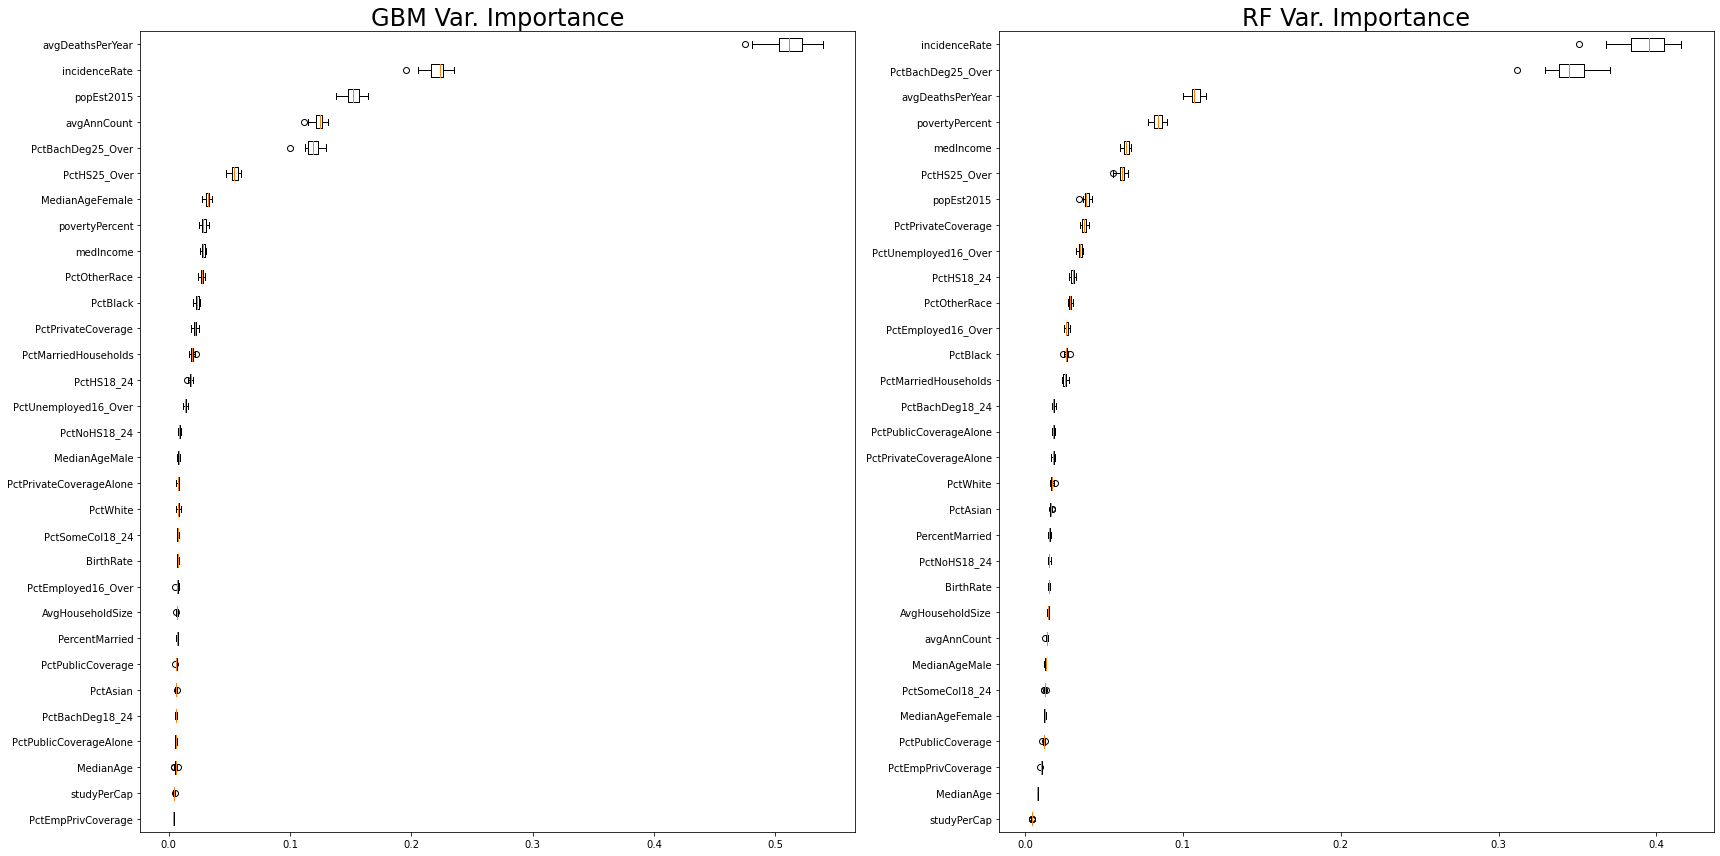

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].boxplot(result_gbm.importances[perm_sorted_idx_gbm].T, vert=False, labels=df.columns[perm_sorted_idx_gbm])
ax[0].set_title("GBM Var. Importance", fontsize=24)
ax[1].boxplot(result_svr_rf.importances[perm_sorted_idx_svr_rf].T, vert=False, labels=df.columns[perm_sorted_idx_svr_rf])
ax[1].set_title("RF Var. Importance", fontsize=24)
fig.tight_layout()
plt.show()

### Results in color

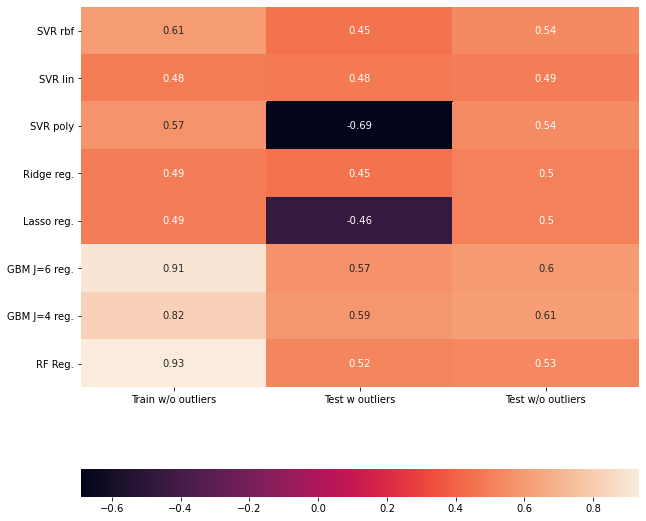

In [ ]:
results_in_color = np.array(results_in_color)
results_in_color_x = np.array(results_in_color_x)
results_in_color_y = np.array(results_in_color_y)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(results_in_color, annot=True, ax=ax, yticklabels=results_in_color_y, xticklabels=results_in_color_x, 
                 cbar_kws={"orientation": "horizontal"})

### Dendogram + Pearson absolute distance

(31, 31) 0.015500049914020986 1.0
(31, 31) 0.0 0.9989547480545027


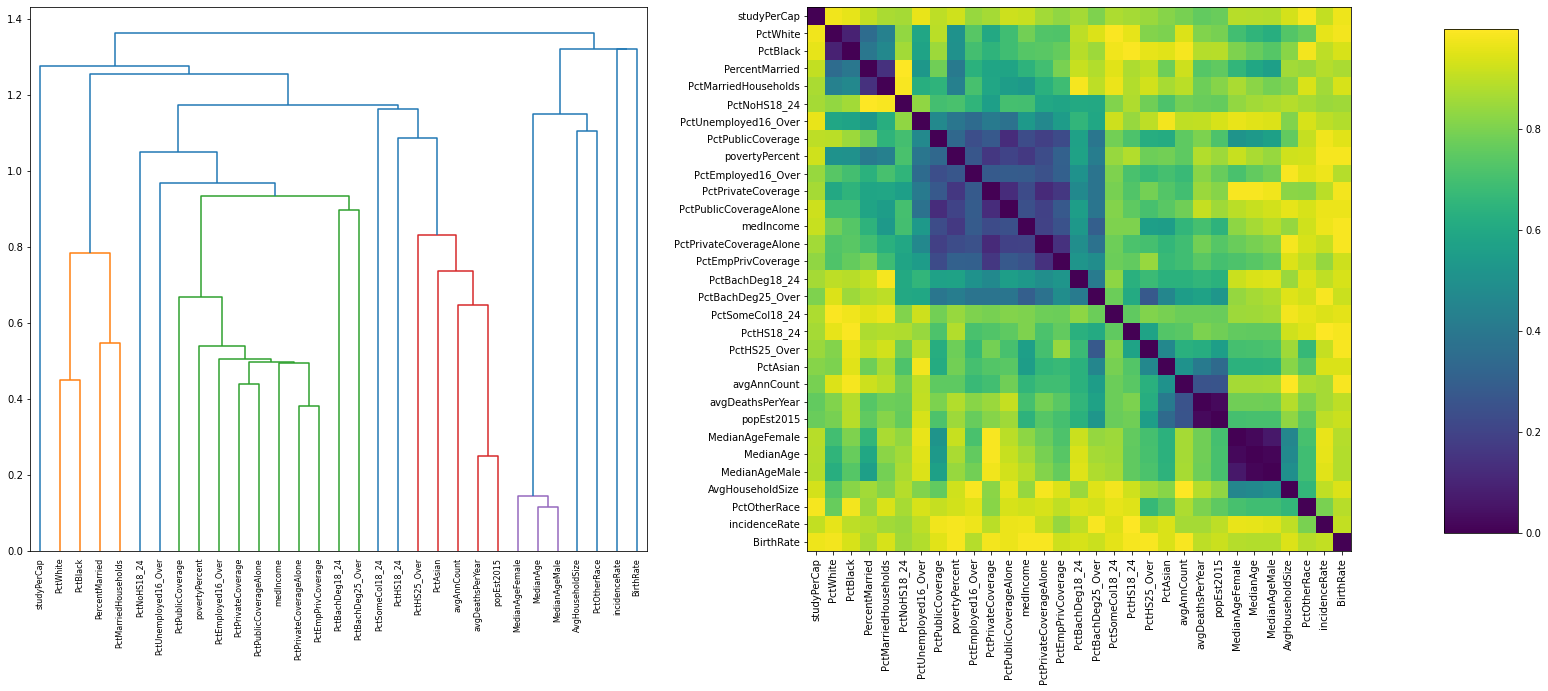

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26, 10))
# corr = spearmanr(X).correlation
corr = squareform(1-pdist(X.T, 'correlation'))
d = 1-np.abs(corr)
print(d.shape, d.min(), d.max())
np.fill_diagonal(d, 0.)
print(d.shape, d.min(), d.max())
corr_linkage = hierarchy.single(d)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=df.columns.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

im2 = ax2.imshow(d[dendro['leaves'], :][:, dendro['leaves']], vmin=d.min(), vmax=d.max())
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])


# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im2, cax=cbar_ax)

plt.show()

### Cut clusters < 0.5 

In [ ]:
L = hierarchy.fcluster(corr_linkage, 0.5, criterion='distance')
print(np.unique(L).size, L.size)

23 31


In [ ]:
feat_id = np.arange(0, X.shape[1], dtype=np.int32)
feat_list = []
for feat in np.unique(L):
    bool_f = L==feat
    sb = bool_f.sum()
    if sb > 2:
#         corr = spearmanr(X[:, bool_f]).correlation
        corr = squareform(pdist(X[:, bool_f].T, 'correlation'))
        d = 1-np.abs(corr)
        feat_red = feat_id[bool_f]
        i_min = feat_red[d.sum(axis=1).argmin()]
        feat_list.append(feat_id[i_min])
    elif sb == 2:
        feat_list.append(feat_id[bool_f].min())
    else:
        feat_list.append(feat_id[bool_f])
feat_list = np.hstack(feat_list)

In [ ]:
X = X[:,feat_list]
X_te = X_te[:,feat_list]
X_ = X_[:,feat_list]
X_te_ = X_te_[:,feat_list]

### Clustering results 

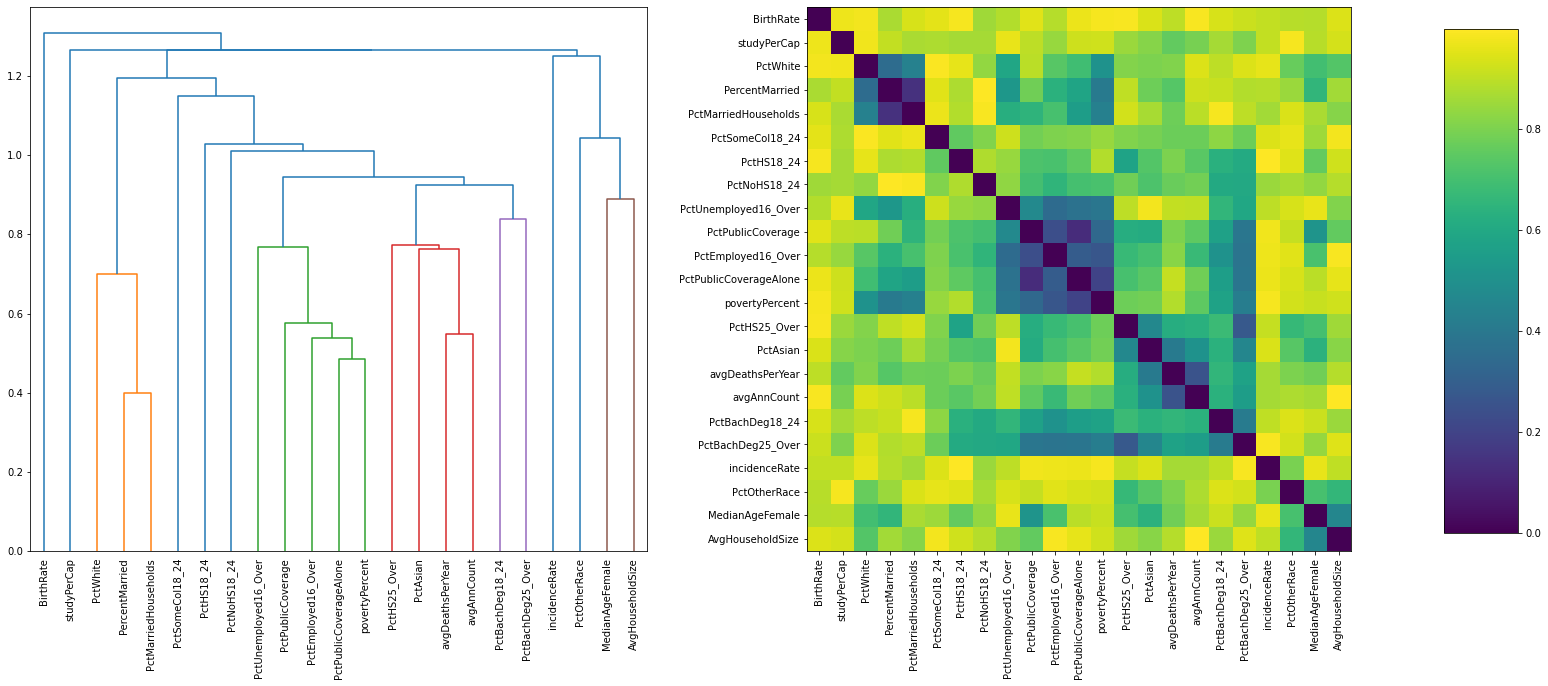

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26, 10))
corr = squareform(1-pdist(X.T, 'correlation'))
d = 1-np.abs(corr)
np.fill_diagonal(d, 0.)
corr_linkage = hierarchy.single(d)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=df.iloc[:, feat_list].columns.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

im2 = ax2.imshow(d[dendro['leaves'], :][:, dendro['leaves']], vmin=d.min(), vmax=d.max())
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])


# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im2, cax=cbar_ax)

plt.show()


### Recluster

In [ ]:
L = hierarchy.fcluster(corr_linkage, 0.5, criterion='distance')
print(np.unique(L).size, L.size)

21 23


In [ ]:
feat_id = np.arange(0, X.shape[1], dtype=np.int32)
feat_list = []
for feat in np.unique(L):
    bool_f = L==feat
    sb = bool_f.sum()
    if sb > 2:
#         corr = spearmanr(X[:, bool_f]).correlation
        corr = squareform(pdist(X[:, bool_f].T, 'correlation'))
        d = 1-np.abs(corr)
        feat_red = feat_id[bool_f]
        i_min = feat_red[d.sum(axis=1).argmin()]
        feat_list.append(feat_id[i_min])
    elif sb == 2:
        feat_list.append(feat_id[bool_f].min())
    else:
        feat_list.append(feat_id[bool_f])
feat_list = np.hstack(feat_list)

In [ ]:
X = X[:,feat_list]
X_te = X_te[:,feat_list]
X_ = X_[:,feat_list]
X_te_ = X_te_[:,feat_list]

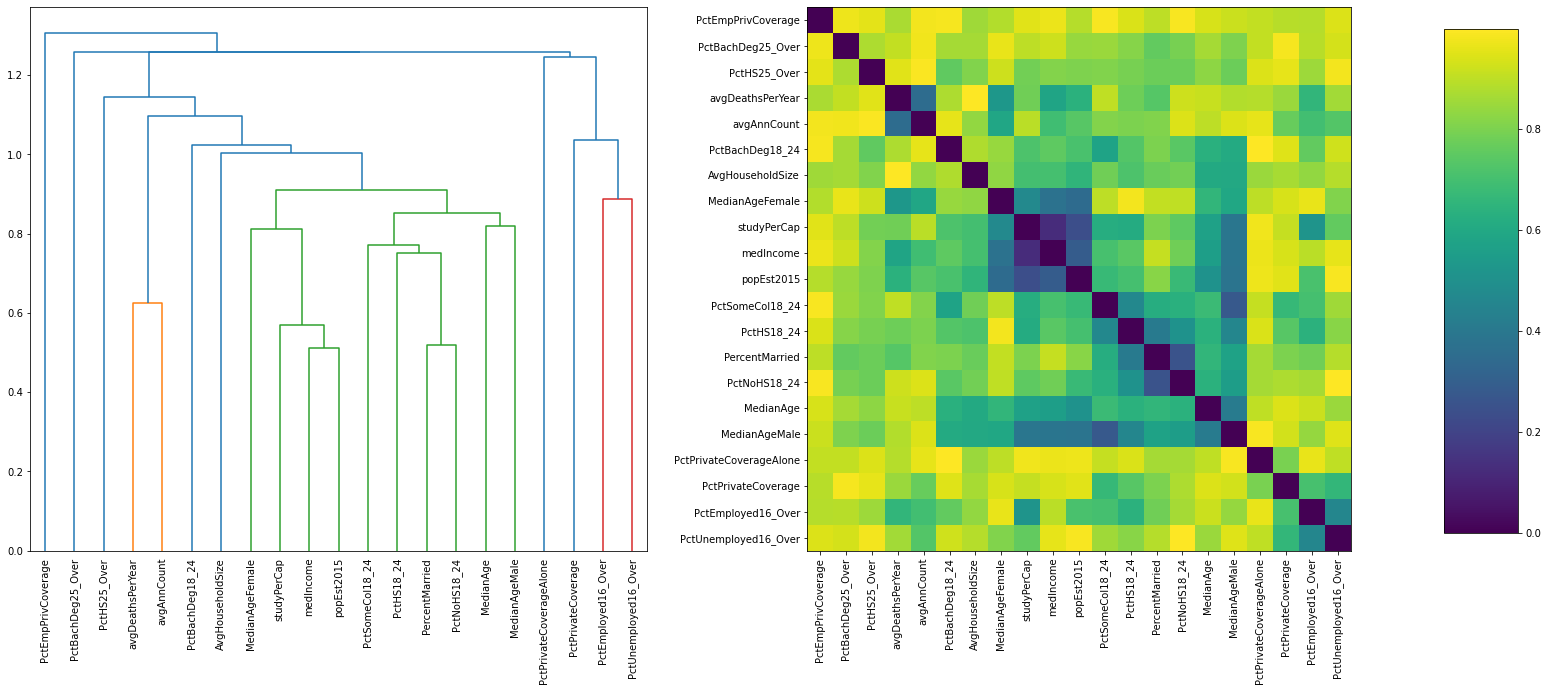

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26, 10))
corr = squareform(1-pdist(X.T, 'correlation'))
d = 1-np.abs(corr)
np.fill_diagonal(d, 0.)
corr_linkage = hierarchy.single(d)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=df.iloc[:, feat_list].columns.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

im2 = ax2.imshow(d[dendro['leaves'], :][:, dendro['leaves']], vmin=d.min(), vmax=d.max())
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])


# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im2, cax=cbar_ax)

plt.show()


### PCA de los datos resultantes

In [ ]:
pc = PCA(n_components=2)
x_pc = pc.fit_transform(X)

kpc = KernelPCA(n_components=2, kernel='rbf', degree=3, gamma=0.0005, fit_inverse_transform=True)
x_kpc = kpc.fit_transform(X)

kpc2 = KernelPCA(n_components=2, kernel='poly', degree=2, gamma=0.0005, fit_inverse_transform=True)
x_kpc2 = kpc2.fit_transform(X)

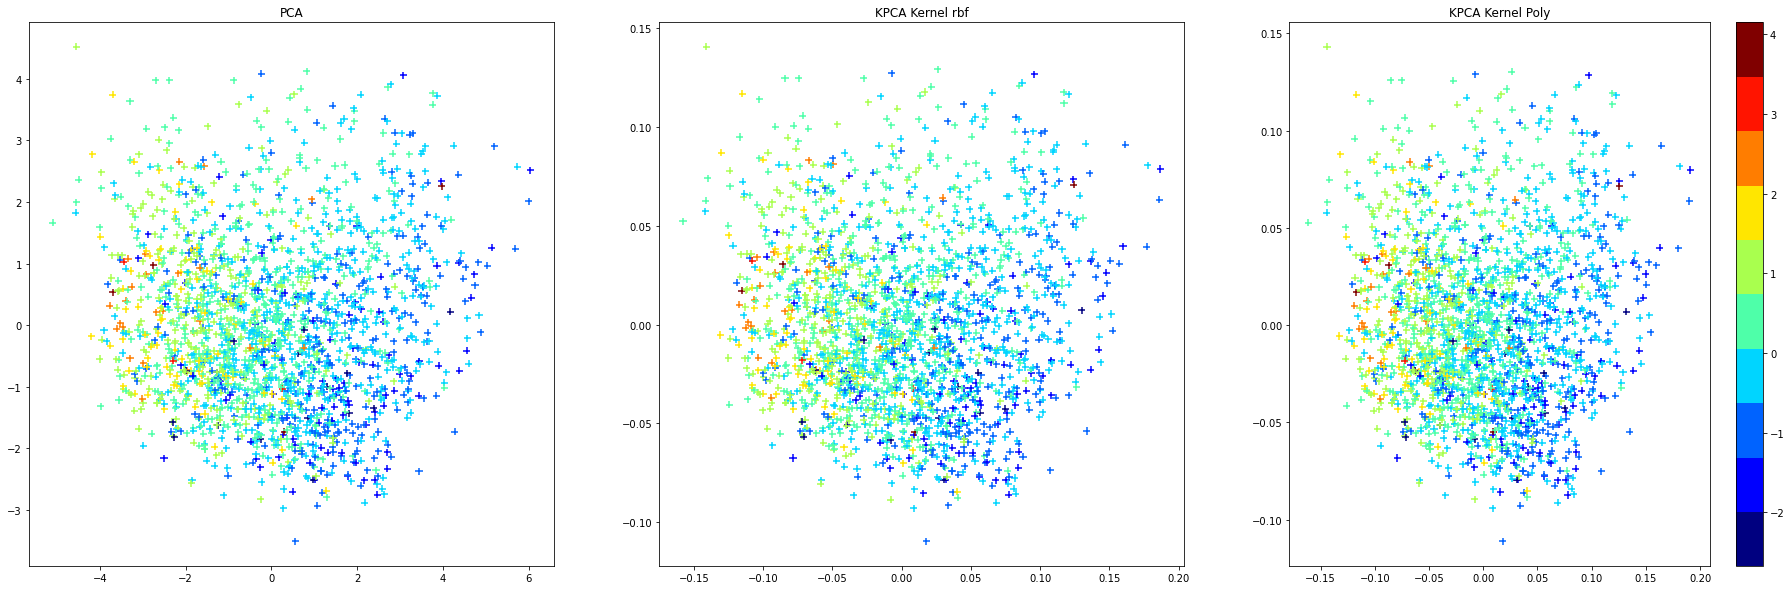

In [ ]:
fig, ax = plt.subplots(1, 3,  figsize=(32, 10))
sc = ax[0].scatter(x_pc[:, 0], x_pc[:, 1], c=y, marker='+', cmap=plt.cm.get_cmap('jet', 10), s=50, vmin=y.min(), vmax=y.max())
ax[0].set_title('PCA')

ax[1].scatter(x_kpc[:, 0], x_kpc[:, 1], c=y, marker='+', cmap=plt.cm.get_cmap('jet', 10), s=50)
ax[1].set_title('KPCA Kernel rbf')

ax[2].scatter(x_kpc2[:, 0], x_kpc2[:, 1], c=y, marker='+', cmap=plt.cm.get_cmap('jet', 10), s=50)
ax[2].set_title('KPCA Kernel Poly')

plt.colorbar(sc)


### TSNE

In [ ]:
model_tsne = TSNE(n_components=2, metric='euclidean')
x_tsne = model_tsne.fit_transform(X)

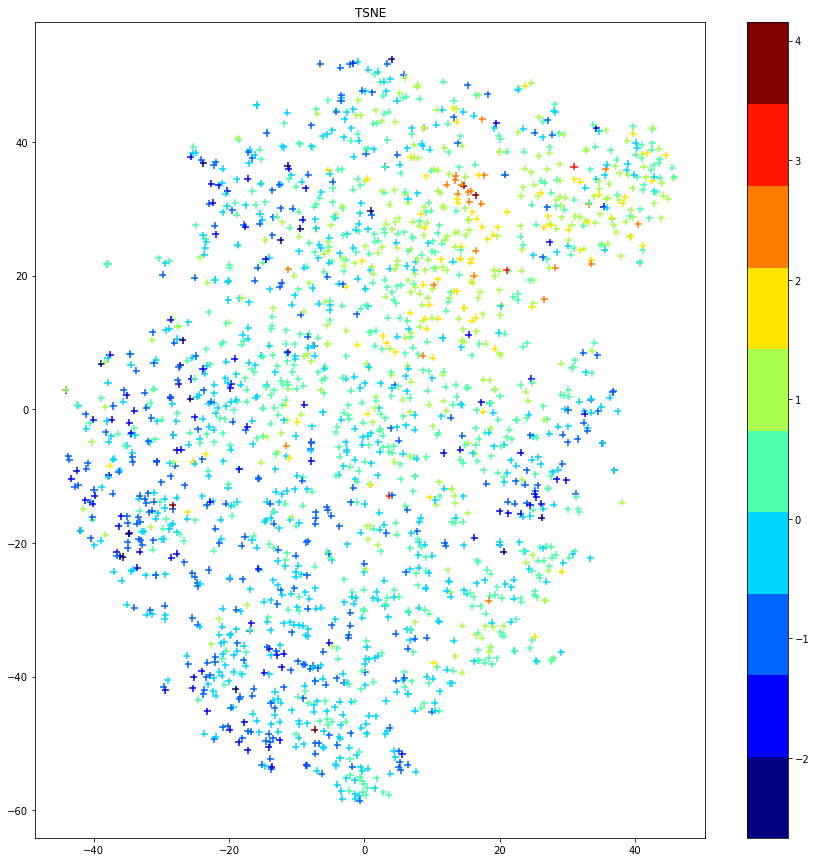

In [ ]:
fig, ax = plt.subplots(1, 1,  figsize=(15, 15))
sc = ax.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, marker='+', cmap=plt.cm.get_cmap('jet', 10), s=50, vmin=y.min(), vmax=y.max())
ax.set_title('TSNE')
plt.colorbar(sc)

In [ ]:
results_in_color_2 = []

results_in_color_x_2 = []
results_in_color_x_2.append('Train w/o outliers')
results_in_color_x_2.append('Test w outliers')
results_in_color_x_2.append('Test w/o outliers')

results_in_color_y_2 = []

In [ ]:
svr_rbf = SVR(kernel='rbf', gamma='auto')
svr_lin = SVR(kernel='linear', gamma='auto')
svr_poly = SVR(kernel='poly', gamma='auto', degree=3, coef0=1)

### SVR rbf

In [ ]:
par = np.logspace(-5, 2, 8)
eps = np.logspace(-4, 0, 5)
cv = KFold(n_splits=5, random_state=0, shuffle=True)
tunner_svr_rbf = GridSearchCV(estimator=svr_rbf, param_grid={'C':par, 'epsilon':eps}, cv=cv, n_jobs=12)
_=tunner_svr_rbf.fit(X, y)
print('RMSE train test')
print(np.sqrt(np.mean((tunner_svr_rbf.predict(X)-y)**2)))
print(np.sqrt(np.mean((tunner_svr_rbf.predict(X_te)-y_te)**2)))
print(np.sqrt(np.mean((tunner_svr_rbf.predict(X_te_)-y_te_)**2)))
print('R2 train test')
print(tunner_svr_rbf.score(X, y))
print(tunner_svr_rbf.score(X_te, y_te))
print(tunner_svr_rbf.score(X_te_, y_te_))
results_in_color_2.append([tunner_svr_rbf.score(X, y), tunner_svr_rbf.score(X_te, y_te), tunner_svr_rbf.score(X_te_, y_te_)])
results_in_color_y_2.append('SVR rbf')

RMSE train test
0.5645628564203228
0.7585120274026884
0.5895606695167891
R2 train test
0.590736831876732
0.43857357677458775
0.5291999300446624


### SVR lin.

In [ ]:
par = np.logspace(-5, 2, 8)
tunner_svr_lin = GridSearchCV(estimator=svr_lin, param_grid={'C':par, 'epsilon':eps}, cv=cv, n_jobs=12)
_=tunner_svr_lin.fit(X, y)
print('RMSE train test')
print(np.sqrt(np.mean((tunner_svr_lin.predict(X)-y)**2)))
print(np.sqrt(np.mean((tunner_svr_lin.predict(X_te)-y_te)**2)))
print(np.sqrt(np.mean((tunner_svr_lin.predict(X_te_)-y_te_)**2)))
print('R2 train test')
print(tunner_svr_lin.score(X, y))
print(tunner_svr_lin.score(X_te, y_te))
print(tunner_svr_lin.score(X_te_, y_te_))
results_in_color_2.append([tunner_svr_lin.score(X, y), tunner_svr_lin.score(X_te, y_te), tunner_svr_lin.score(X_te_, y_te_)])
results_in_color_y_2.append('SVR lin')

RMSE train test
0.648577818458751
0.6950436283844457
0.6157658790636613
R2 train test
0.45986509746626625
0.5285973297465465
0.48641686732787126


### SVR poly

In [ ]:
par = np.logspace(-5, 2, 8)
# tunner_svc = GridSearchCV(estimator=svc, param_grid={'C':par, 'gamma':par_gamma}, cv=cv, n_jobs=12)
tunner_svr_poly = GridSearchCV(estimator=svr_poly, param_grid={'C':par, 'epsilon':eps}, cv=cv, n_jobs=12)
_=tunner_svr_poly.fit(X, y)
print('RMSE train test')
print(np.sqrt(np.mean((tunner_svr_poly.predict(X)-y)**2)))
print(np.sqrt(np.mean((tunner_svr_poly.predict(X_te)-y_te)**2)))
print(np.sqrt(np.mean((tunner_svr_poly.predict(X_te_)-y_te_)**2)))
print('R2 train test')
print(tunner_svr_poly.score(X, y))
print(tunner_svr_poly.score(X_te, y_te))
print(tunner_svr_poly.score(X_te_, y_te_))
results_in_color_2.append([tunner_svr_poly.score(X, y), tunner_svr_poly.score(X_te, y_te), tunner_svr_poly.score(X_te_, y_te_)])
results_in_color_y_2.append('SVR poly.')

RMSE train test
0.5980171856258302
2.026336373556881
0.5933304925783418
R2 train test
0.5407962902994363
-3.0067383784619963
0.5231598142321772


### Ridge reg.

In [ ]:
alpha_par = np.arange(0, 1, 0.05)
lmr = Ridge()
tunner_lmr = GridSearchCV(estimator=lmr, param_grid={'alpha':alpha_par}, cv=cv, n_jobs=12)
_=tunner_lmr.fit(X, y)
print('RMSE train test')
print(np.sqrt(np.mean((tunner_lmr.predict(X)-y)**2)))
print(np.sqrt(np.mean((tunner_lmr.predict(X_te)-y_te)**2)))
print(np.sqrt(np.mean((tunner_lmr.predict(X_te_)-y_te_)**2)))
print('R2 train test')
print(tunner_lmr.score(X, y))
print(tunner_lmr.score(X_te, y_te))
print(tunner_lmr.score(X_te_, y_te_))
results_in_color_2.append([tunner_lmr.score(X, y), tunner_lmr.score(X_te, y_te), tunner_lmr.score(X_te_, y_te_)])
results_in_color_y_2.append('Ridge reg.')

RMSE train test
0.6456008249968886
0.6936452676022727
0.6194061474898899
R2 train test
0.46481219152855624
0.5304922550876882
0.48032654373570394


### Lasso reg.

In [ ]:
alpha_par = np.arange(0, 1, 0.05)
lml = Lasso()
tunner_lml = GridSearchCV(estimator=lml, param_grid={'alpha':alpha_par}, cv=cv, n_jobs=12)
_=tunner_lml.fit(X, y)
print('RMSE train test')
print(np.sqrt(np.mean((tunner_lml.predict(X)-y)**2)))
print(np.sqrt(np.mean((tunner_lml.predict(X_te)-y_te)**2)))
print(np.sqrt(np.mean((tunner_lml.predict(X_te_)-y_te_)**2)))
print('R2 train test')
print(tunner_lml.score(X, y))
print(tunner_lml.score(X_te, y_te))
print(tunner_lml.score(X_te_, y_te_))
results_in_color_2.append([tunner_lml.score(X, y), tunner_lml.score(X_te, y_te), tunner_lml.score(X_te_, y_te_)])
results_in_color_y_2.append('Lasso reg.')

RMSE train test
0.6455998687986209
0.6939096159118462
0.619515897105855
R2 train test
0.46481377685886127
0.5301343279616817
0.4801423705069716


### Revisamos los modelos nuevamente

(-0.05, 0.7)

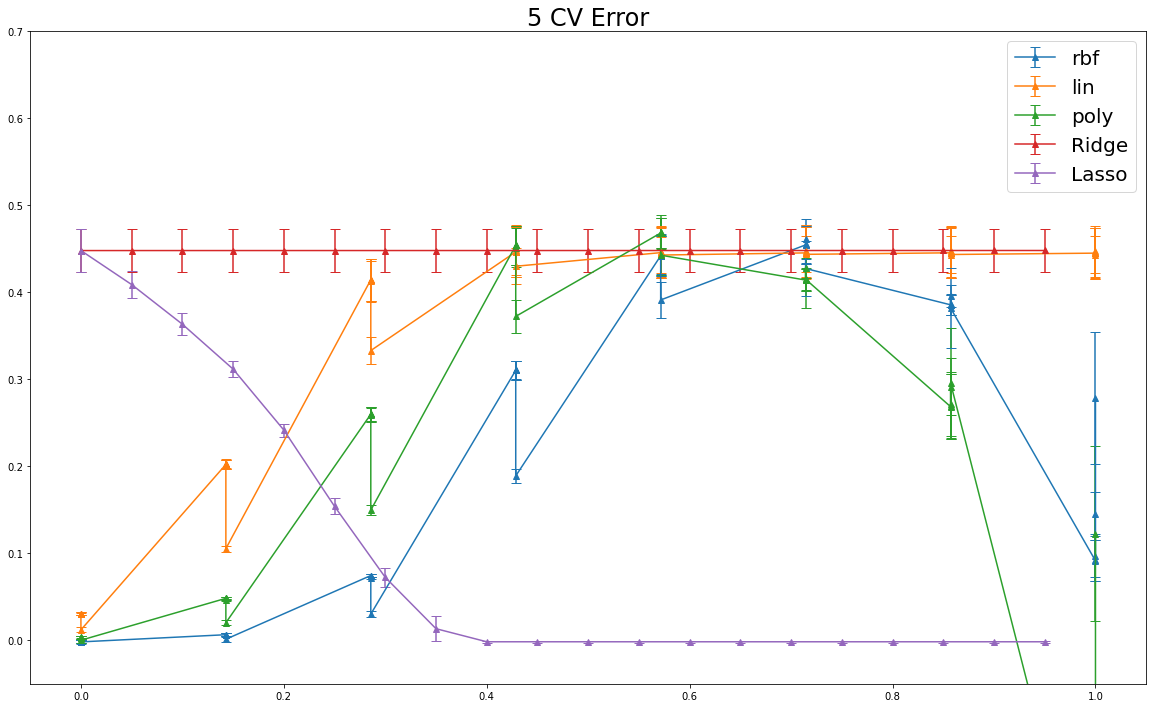

In [ ]:
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111)
xx = np.log10(np.array(tunner_svr_rbf.cv_results_['param_C'], dtype=np.float64))
xx -= xx.min()
xx /= xx.max()
ax.errorbar(xx, tunner_svr_rbf.cv_results_['mean_test_score'], yerr=tunner_svr_rbf.cv_results_['std_test_score'], capsize=5,marker='^', label='rbf')
ax.errorbar(xx, tunner_svr_lin.cv_results_['mean_test_score'], yerr=tunner_svr_lin.cv_results_['std_test_score'], capsize=5,marker='^', label='lin')
ax.errorbar(xx, tunner_svr_poly.cv_results_['mean_test_score'], yerr=tunner_svr_poly.cv_results_['std_test_score'], capsize=5,marker='^', label='poly')
ax.errorbar(tunner_lmr.cv_results_['param_alpha'], tunner_lmr.cv_results_['mean_test_score'], yerr=tunner_lmr.cv_results_['std_test_score'], capsize=5,marker='^', label='Ridge')
ax.errorbar(tunner_lml.cv_results_['param_alpha'], tunner_lml.cv_results_['mean_test_score'], yerr=tunner_lml.cv_results_['std_test_score'], capsize=5,marker='^', label='Lasso')
_=ax.set_title('5 CV Error', fontsize=24)
ax.legend(loc='best', fontsize=20)
ax.set_ylim([-0.05, 0.7])

### Importancia de variables [permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html) usando

* Ridge
* SVR Lineal

In [ ]:
result_lmr = permutation_importance(tunner_lmr, X, y, n_repeats=30, random_state=42, n_jobs=12)
perm_sorted_idx_lmr = result_lmr.importances_mean.argsort()

result_svr_lin = permutation_importance(tunner_svr_rbf, X, y, n_repeats=30, random_state=42, n_jobs=12)
perm_sorted_idx_svr_lin = result_svr_lin.importances_mean.argsort()

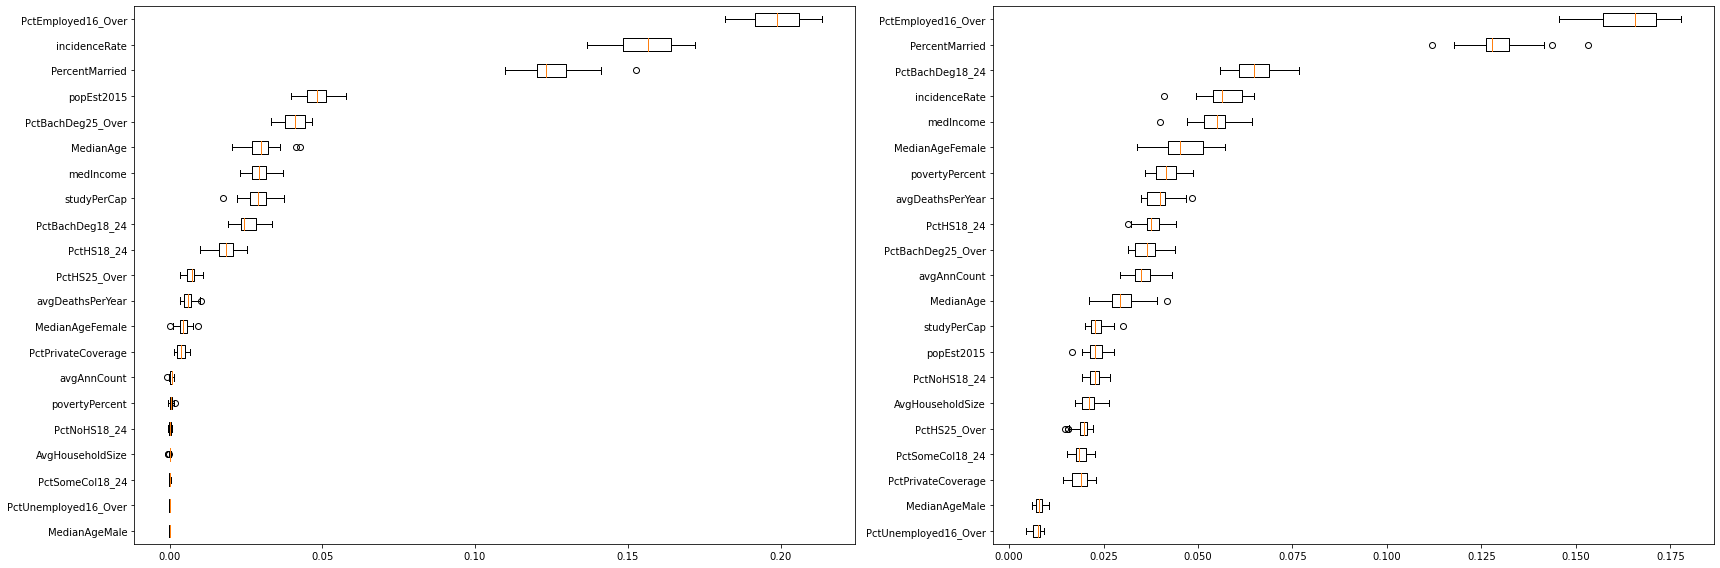

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(24, 8))
ax[0].boxplot(result_lmr.importances[perm_sorted_idx_lmr].T, vert=False, labels=df.columns[perm_sorted_idx_lmr])
ax[1].boxplot(result_svr_lin.importances[perm_sorted_idx_svr_lin].T, vert=False, labels=df.columns[perm_sorted_idx_svr_lin])
fig.tight_layout()
plt.show()


## GBM OOB J=6

In [ ]:
gbm = GradientBoostingRegressor(learning_rate=0.02, n_estimators=1000, subsample=0.6, max_depth=6)
gbm.fit(X, y)

GradientBoostingRegressor(learning_rate=0.02, max_depth=6, n_estimators=1000,
                          subsample=0.6)

n_estimators:  317  oob_improvement_:  -0.3525687028735277


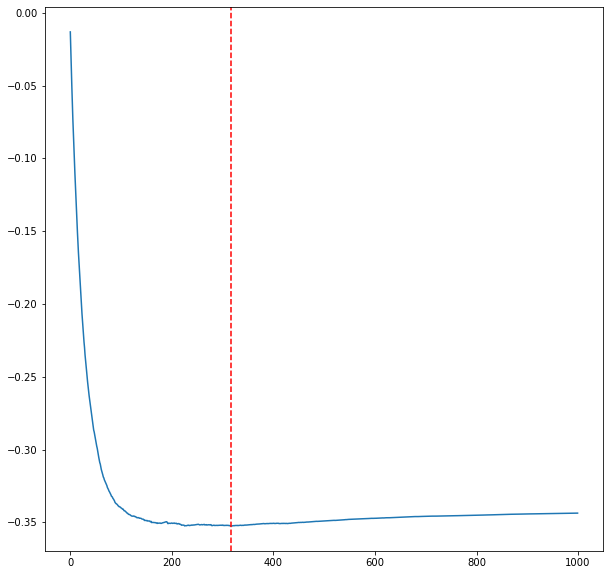

In [ ]:
cumsum_oob = -np.cumsum(gbm.oob_improvement_)
iimin = cumsum_oob.argmin()
print('n_estimators: ', iimin+1, ' oob_improvement_: ', cumsum_oob[iimin])
fig, ax = plt.subplots(1, 1,  figsize=(10, 10))
plt.plot(cumsum_oob)
plt.axvline(x=iimin, c='r', linestyle='--')

In [ ]:
gbm = GradientBoostingRegressor(learning_rate=0.02, n_estimators=iimin+1, subsample=0.6, max_depth=6)
gbm.fit(X, y)
print(gbm.oob_improvement_.sum())
print('RMSE train test')
print(np.sqrt(np.mean((gbm.predict(X)-y)**2)))
print(np.sqrt(np.mean((gbm.predict(X_te)-y_te)**2)))
print(np.sqrt(np.mean((gbm.predict(X_te_)-y_te_)**2)))
print('R2 train test')
print(gbm.score(X, y))
print(gbm.score(X_te, y_te))
print(gbm.score(X_te_, y_te_))
results_in_color_2.append([gbm.score(X, y), gbm.score(X_te, y_te), gbm.score(X_te_, y_te_)])
results_in_color_y_2.append('GBM J=6 reg.')

0.3448947167452824
RMSE train test
0.27792658996499015
0.6790879495549895
0.5654903852972955
R2 train test
0.9008167680347778
0.549992291339467
0.5668583341460647


## GBM OOB J=4

In [ ]:
gbm = GradientBoostingRegressor(learning_rate=0.02, n_estimators=1000, subsample=0.6, max_depth=4)
gbm.fit(X, y)

GradientBoostingRegressor(learning_rate=0.02, max_depth=4, n_estimators=1000,
                          subsample=0.6)

n_estimators:  288  oob_improvement_:  -0.34379150490960886


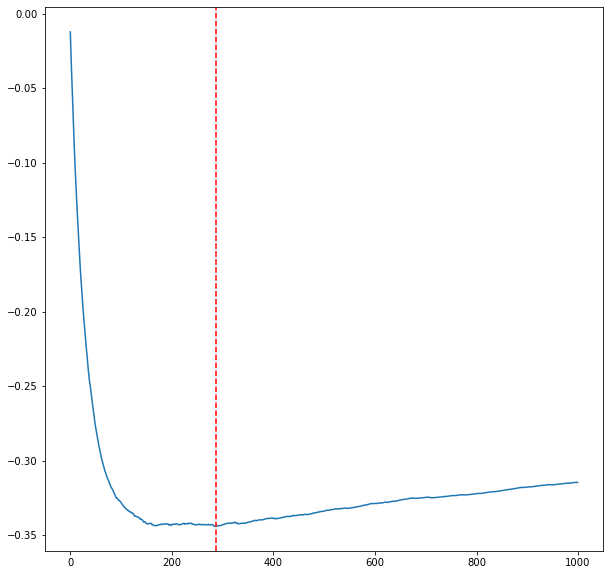

In [ ]:
cumsum_oob = -np.cumsum(gbm.oob_improvement_)
iimin = cumsum_oob.argmin()
print('n_estimators: ', iimin+1, ' oob_improvement_: ', cumsum_oob[iimin])
fig, ax = plt.subplots(1, 1,  figsize=(10, 10))
plt.plot(cumsum_oob)
plt.axvline(x=iimin, c='r', linestyle='--')

In [ ]:
gbm = GradientBoostingRegressor(learning_rate=0.02, n_estimators=iimin+1, subsample=0.6, max_depth=4)
gbm.fit(X, y)
print(gbm.oob_improvement_.sum())
print('RMSE train test')
print(np.sqrt(np.mean((gbm.predict(X)-y)**2)))
print(np.sqrt(np.mean((gbm.predict(X_te)-y_te)**2)))
print(np.sqrt(np.mean((gbm.predict(X_te_)-y_te_)**2)))
print('R2 train test')
print(gbm.score(X, y))
print(gbm.score(X_te, y_te))
print(gbm.score(X_te_, y_te_))
results_in_color_2.append([gbm.score(X, y), gbm.score(X_te, y_te), gbm.score(X_te_, y_te_)])
results_in_color_y_2.append('GBM J=4 reg.')

0.3435561770874006
RMSE train test
0.4497351782375407
0.6814865167187212
0.5722275950459701
R2 train test
0.7402881433093322
0.5468077850887645
0.5564760191279265


### RF reg.

In [ ]:
n_est = np.array([500, 1000, 2000])
rfl = [RandomForestRegressor(n_estimators=n, n_jobs=-1, oob_score=True) for n in n_est]
_ = [rf.fit(X, y) for rf in rfl]
oob_score = np.array([rf.oob_score_ for rf in rfl])
print(oob_score)
rf = RandomForestRegressor(n_estimators=n_est[n_est.argmax()], n_jobs=-1, oob_score=True)
rf.fit(X, y)
print('RMSE train test')
print(np.sqrt(np.mean((rf.predict(X)-y)**2)))
print(np.sqrt(np.mean((rf.predict(X_te)-y_te)**2)))
print(np.sqrt(np.mean((rf.predict(X_te_)-y_te_)**2)))
print('R2 train test')
print(rf.score(X, y))
print(rf.score(X_te, y_te))
print(rf.score(X_te_, y_te_))
results_in_color_2.append([rf.score(X, y), rf.score(X_te, y_te), rf.score(X_te_, y_te_)])
results_in_color_y_2.append('RF reg.')

[0.47837227 0.48083776 0.48017635]
RMSE train test
0.23496214984073222
0.7073733038831979
0.6028758625065891
R2 train test
0.9291118124238797
0.5117241591021451
0.5076938008603671


### Importancia de variables [permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html) usando

* GBM
* RF

In [ ]:
result_gbm = permutation_importance(gbm, X, y, n_repeats=30, random_state=42, n_jobs=12)
perm_sorted_idx_gbm = result_gbm.importances_mean.argsort()
result_svr_rf = permutation_importance(rf, X, y, n_repeats=30, random_state=42, n_jobs=12)
perm_sorted_idx_svr_rf = result_svr_rf.importances_mean.argsort()

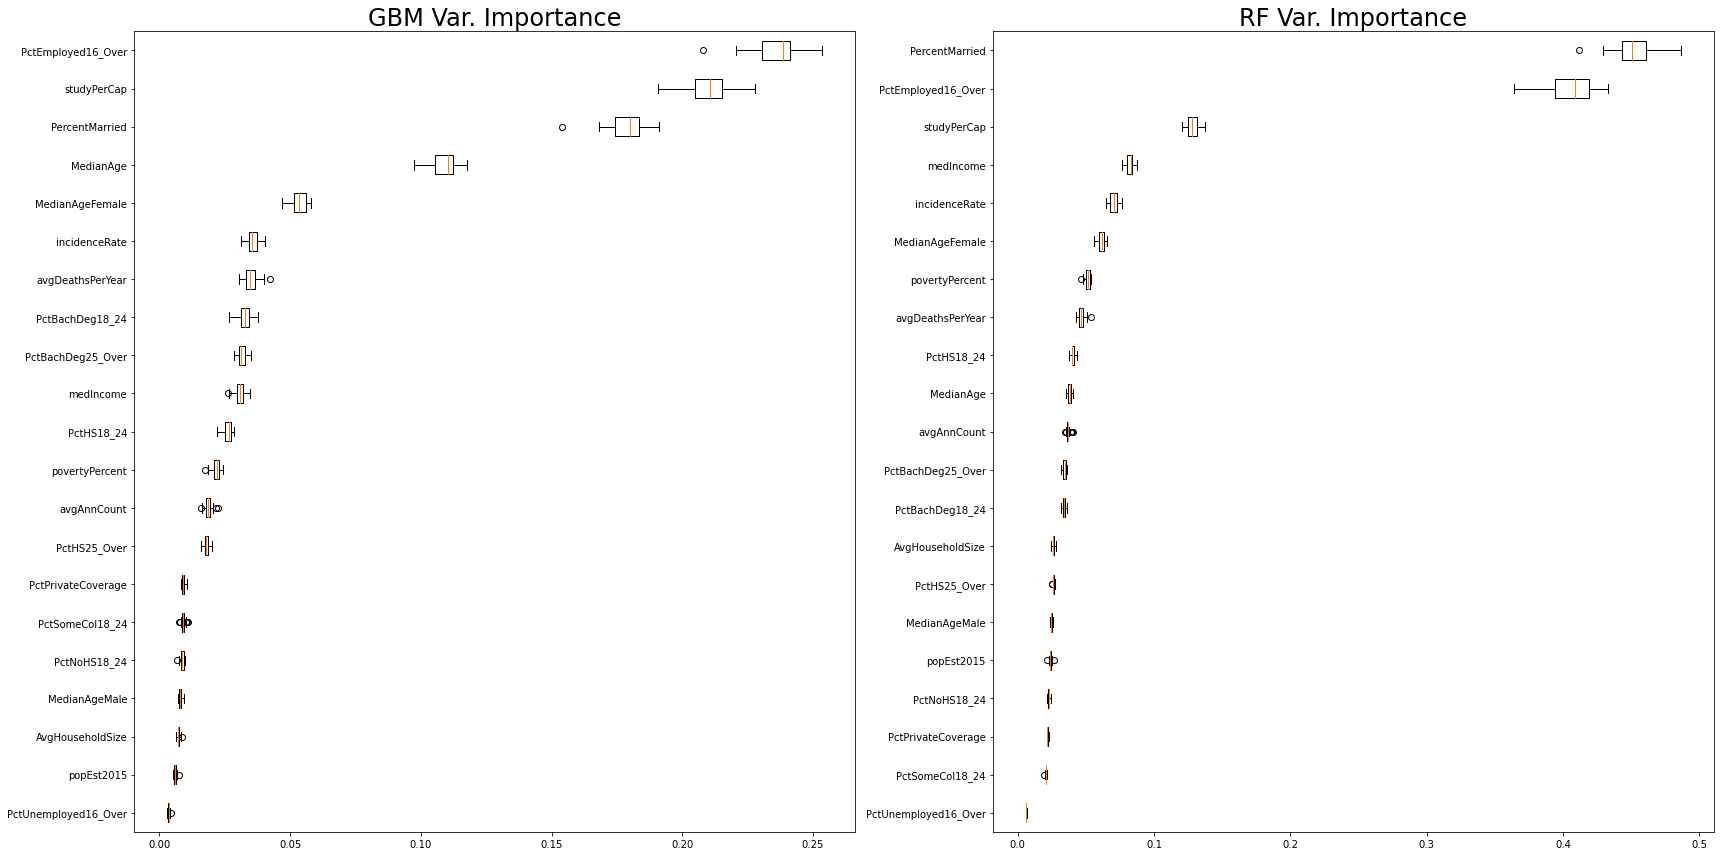

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].boxplot(result_gbm.importances[perm_sorted_idx_gbm].T, vert=False, labels=df.columns[perm_sorted_idx_gbm])
ax[0].set_title("GBM Var. Importance", fontsize=24)
ax[1].boxplot(result_svr_rf.importances[perm_sorted_idx_svr_rf].T, vert=False, labels=df.columns[perm_sorted_idx_svr_rf])
ax[1].set_title("RF Var. Importance", fontsize=24)
fig.tight_layout()
plt.show()

Text(0.5, 1.0, '21 variables')

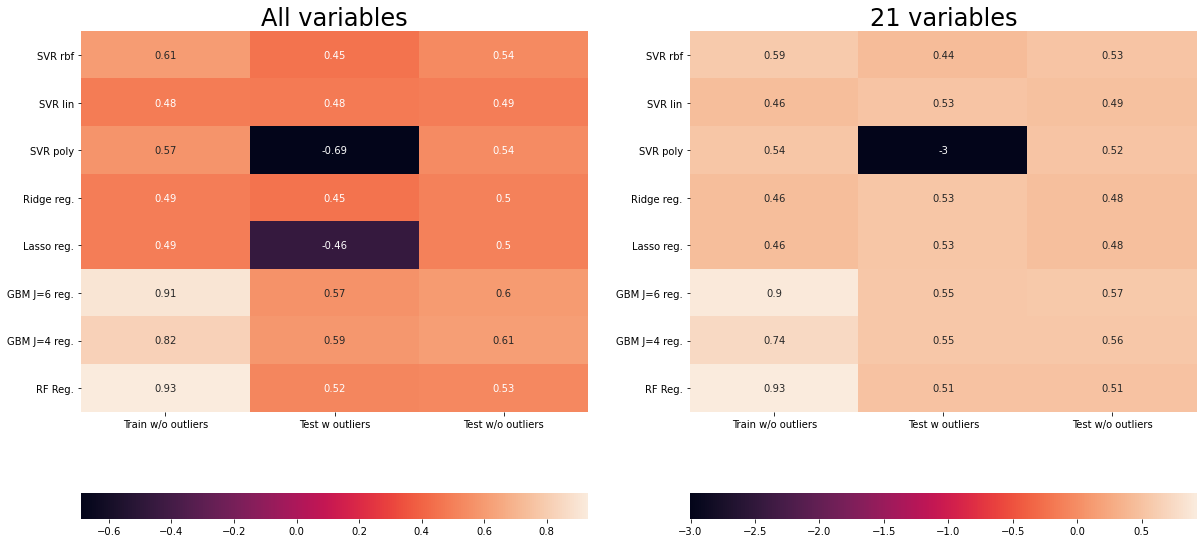

In [ ]:
results_in_color_2 = np.array(results_in_color_2)
results_in_color_x_2 = np.array(results_in_color_x_2)
results_in_color_y_2 = np.array(results_in_color_y_2)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0] = sns.heatmap(results_in_color, annot=True, ax=ax[0], yticklabels=results_in_color_y, xticklabels=results_in_color_x,
                    cbar_kws={"orientation": "horizontal"})
ax[0].set_title('All variables', fontsize=24)
ax[1] = sns.heatmap(results_in_color_2, annot=True, ax=ax[1], yticklabels=results_in_color_y, xticklabels=results_in_color_x,
                    cbar_kws={"orientation": "horizontal"})
ax[1].set_title('21 variables', fontsize=24)